# Dogs vs Cats Redux competition
## Lession 1



In [1]:
# Verify we are in the fastai directory
%pwd

u'/home/pmaroun/source/fastai'

In [24]:
# Create references to important directories that we will repeatedly use
import os, sys

# the ~ refers to your home directory in the linux prompt but jupyter does not recognize that symbol, 
# you either provide a full path (something like /home/yoursusename/data//dogscats/sample) 
# or a correct relative path from the location where you launch jupyter

current_dir = os.getcwd()
LESSON_HOME_DIR = current_dir
DATA_HOME_DIR = os.path.realpath("/home/pmaroun/data/dogs-vs-cats-redux/")

#Allow relative imports to directories above lesson1/
sys.path.insert(1, os.path.join(sys.path[0], '..'))

#path = os.path.realpath("../../data/dogs-vs-cats-redux/")
#os.listdir(DATA_HOME_DIR)
#print(path)

#sys.exit()

from glob import glob

#%cd $DATA_HOME_DIR/test

#from shutil import copyfile
#g = glob('*.jpg')
#shuf = np.random.permutation(g)
#for i in range(200): copyfile(shuf[i], DATA_HOME_DIR+'/sample/test/' + shuf[i])

/home/pmaroun/data/dogs-vs-cats-redux/test


In [3]:
#import modules
from utils import *
from vgg16 import Vgg16
import json

from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

from utils import plots

from __future__ import division,print_function

#Instantiate plotting tool
#In Jupyter notebooks, you will need to run this command before doing any plotting
%matplotlib inline


Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/pmaroun/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


# Finetuning and training

In [4]:
train_path = DATA_HOME_DIR + '/train/'
valid_path = DATA_HOME_DIR + '/valid/'
test_path = DATA_HOME_DIR + '/test/'

results_path = DATA_HOME_DIR + '/results/'

vgg = Vgg16()
batch_size=64
num_epochs = 3

batches = vgg.get_batches(train_path, batch_size=batch_size)
val_batches = vgg.get_batches(valid_path, batch_size=batch_size)
vgg.finetune(batches)

#Not sure if we set this for all fits
#vgg.model.optimizer.lr = 0.01

/home/pmaroun/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:577: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


Found 22500 images belonging to 2 classes.
Found 22500 images belonging to 2 classes.


In [7]:
#Notice we are passing in the validation dataset to the fit() method
#For each epoch we test our model against the validation set
latest_weights_filename = None
for epoch in range(num_epochs):
    print ("Running epoch: %d" % epoch)
    vgg.fit(batches, val_batches, nb_epoch=1)
    latest_weights_filename = 'ft%d.h5' % epoch
    vgg.model.save_weights(results_path+latest_weights_filename)
print ("Completed %s fit operations" % epoch)

Running epoch: 0
Epoch 1/1
22500/22500 [==============================] - 1475s - loss: 0.3389 - acc: 0.9751 - val_loss: 0.3146 - val_acc: 0.9766
Running epoch: 1
Epoch 1/1
22500/22500 [==============================] - 1470s - loss: 0.3373 - acc: 0.9762 - val_loss: 0.2391 - val_acc: 0.9834
Running epoch: 2
Epoch 1/1
22500/22500 [==============================] - 1471s - loss: 0.3283 - acc: 0.9775 - val_loss: 0.2256 - val_acc: 0.9840


NameError: name 'no_of_epochs' is not defined

In [8]:
#My initial approach to solving this problem
def predict(base_train_folder, vgg):
    from keras.preprocessing import image
    import pandas as pd
    imags = glob(os.path.join(base_train_folder, 'test','*.jpg'))

    records = []
    for n, path_img in enumerate(imags):
        probs = vgg.model.predict(
            image.img_to_array(image.load_img(path_img, target_size=[224, 224])).reshape(1, 3,
                                                                         224,
                                                                         224))
        base = os.path.basename(path_img)
        number = os.path.splitext(base)[0]
        
        records.append({'id': number, 'label': probs[0][1]})
    
        print ({'id': number, 'label': probs[0][1]})

    print(len(records))
    df = pd.DataFrame.from_records(records)
    df['id'] = pd.to_numeric(df['id'])
    df = df.sort_values('id')
    df.to_csv('submission.csv', index=False)

In [9]:
#using my initial approach:
# predict(path, vgg)

In [27]:
test_path = DATA_HOME_DIR + '/test/'
os.listdir(test_path)
batches, preds = vgg.test(test_path, batch_size = batch_size)

Found 12500 images belonging to 1 classes.


In [28]:
#For every image, vgg.test() generates two probabilities 
#based on how we've ordered the cats/dogs directories.
#It looks like column one is cats and column two is dogs
print (preds[:5])

filenames = batches.filenames
print (filenames[:5])

[[ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]]
['unknown/891.jpg', 'unknown/10799.jpg', 'unknown/4101.jpg', 'unknown/5139.jpg', 'unknown/2779.jpg']


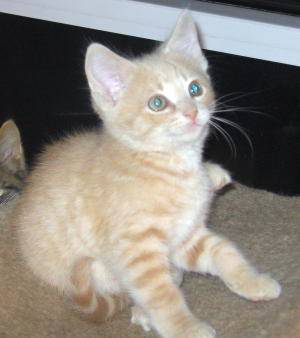

In [29]:
#You can verify the column ordering by viewing some images
from PIL import Image
Image.open(test_path + filenames[2])

In [30]:
#Save our test results arrays so we can use them again later
save_array(results_path + 'test_preds.dat', preds)
save_array(results_path + 'filenames.dat', filenames)

## Validate Predictions ##

Keras' fit() function conveniently shows us the value of the loss function, and the accuracy, after every epoch ("epoch" refers to one full run through all training examples). The most important metrics for us to look at are for the validation set, since we want to check for over-fitting.

Tip: with our first model we should try to overfit before we start worrying about how to reduce over-fitting - there's no point even thinking about regularization, data augmentation, etc if you're still under-fitting! (We'll be looking at these techniques shortly).

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (ie those with highest probability that are correct)
4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
5. The most uncertain labels (ie those with probability closest to 0.5).

Let's see what we can learn from these examples. (In general, this is a particularly useful technique for debugging problems in the model. However, since this model is so simple, there may not be too much to learn at this stage.)
Calculate predictions on validation set, so we can find correct and incorrect examples:

In [31]:
vgg.model.load_weights(results_path+latest_weights_filename)

In [32]:
val_batches, probs = vgg.test(valid_path, batch_size = batch_size)

Found 22500 images belonging to 2 classes.


In [33]:
filenames = val_batches.filenames
expected_labels = val_batches.classes #0 or 1

#Round our predictions to 0/1 to generate labels
our_predictions = probs[:,0]
our_labels = np.round(1-our_predictions)

In [34]:
from keras.preprocessing import image

#Helper function to plot images by index in the validation set 
#Plots is a helper function in utils.py
def plots_idx(idx, titles=None):
    plots([image.load_img(valid_path + filenames[i]) for i in idx], titles=titles)
    
#Number of images to view for each visualization task
n_view = 4

Found 22136 correct labels


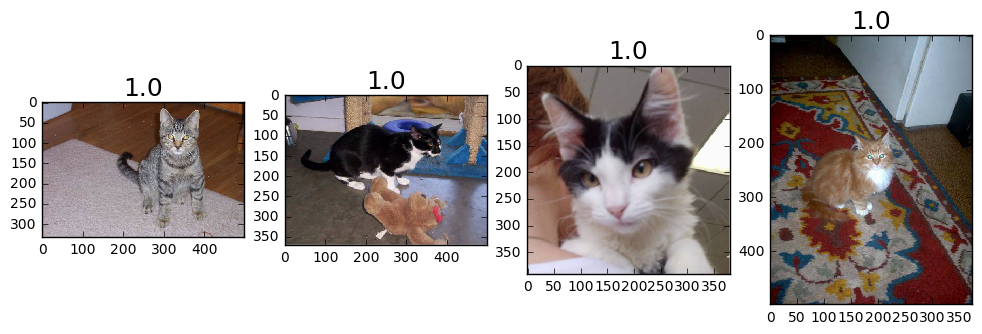

In [35]:
#1. A few correct labels at random
correct = np.where(our_labels==expected_labels)[0]
print ("Found %d correct labels" % len(correct))
idx = permutation(correct)[:n_view]
plots_idx(idx, our_predictions[idx])

Found 364 incorrect labels


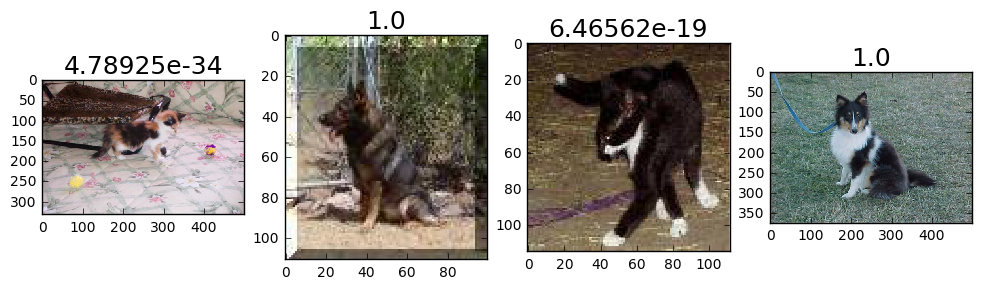

In [43]:
#2. A few incorrect labels at random
incorrect = np.where(our_labels!=expected_labels)[0]
print ("Found %d incorrect labels" % len(incorrect))
idx = permutation(incorrect)[:n_view]
plots_idx(idx, our_predictions[idx])

Found 11129 confident correct cats labels


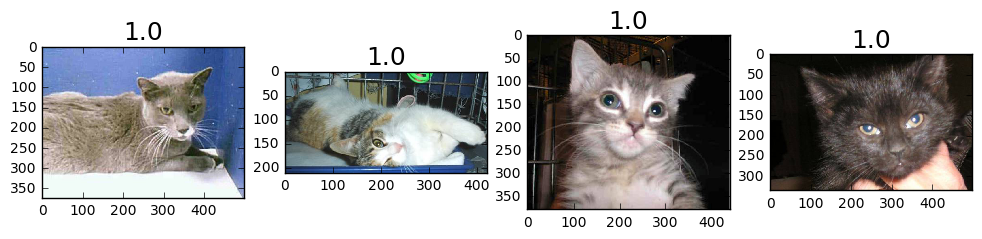

In [37]:
#3a. The images we most confident were cats, and are actually cats
correct_cats = np.where((our_labels==0) & (our_labels==expected_labels))[0]
print ("Found %d confident correct cats labels" % len(correct_cats))
most_correct_cats = np.argsort(our_predictions[correct_cats])[::-1][:n_view]
plots_idx(correct_cats[most_correct_cats], our_predictions[correct_cats][most_correct_cats])

Found 267 incorrect cats


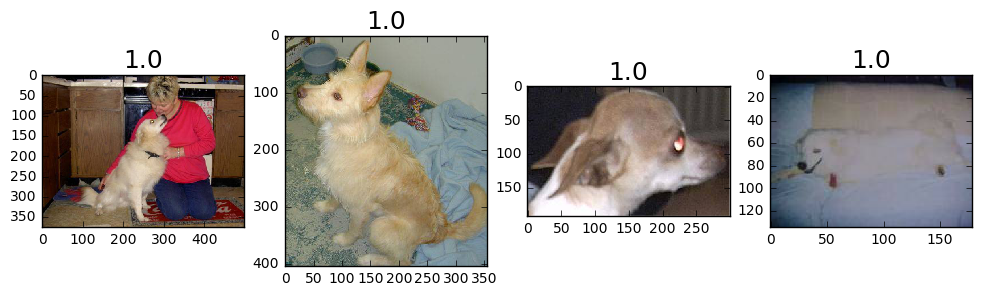

In [38]:
#4a. The images we were most confident were cats, but are actually dogs
incorrect_cats = np.where((our_labels==0) & (our_labels!=expected_labels))[0]
print ("Found %d incorrect cats" % len(incorrect_cats))
if len(incorrect_cats):
    most_incorrect_cats = np.argsort(our_predictions[incorrect_cats])[::-1][:n_view]
    plots_idx(incorrect_cats[most_incorrect_cats], our_predictions[incorrect_cats][most_incorrect_cats])

Found 97 incorrect dogs


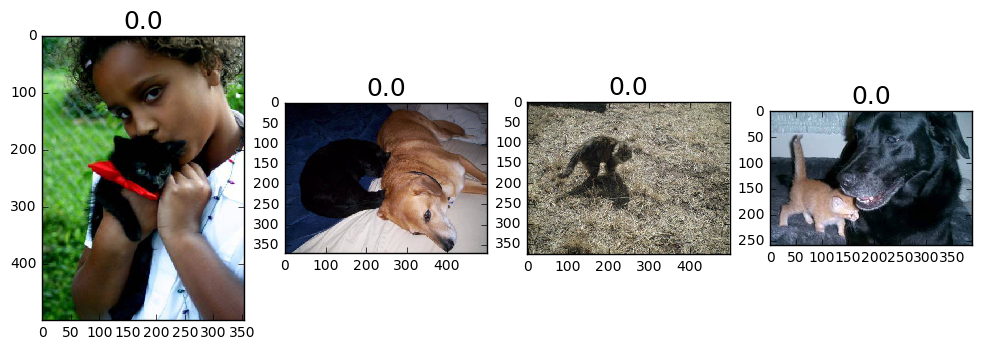

In [39]:
#4b. The images we were most confident were dogs, but are actually cats
incorrect_dogs = np.where((our_labels==1) & (our_labels!=expected_labels))[0]
print ("Found %d incorrect dogs" % len(incorrect_dogs))
if len(incorrect_dogs):
    most_incorrect_dogs = np.argsort(our_predictions[incorrect_dogs])[:n_view]
    plots_idx(incorrect_dogs[most_incorrect_dogs], our_predictions[incorrect_dogs][most_incorrect_dogs])

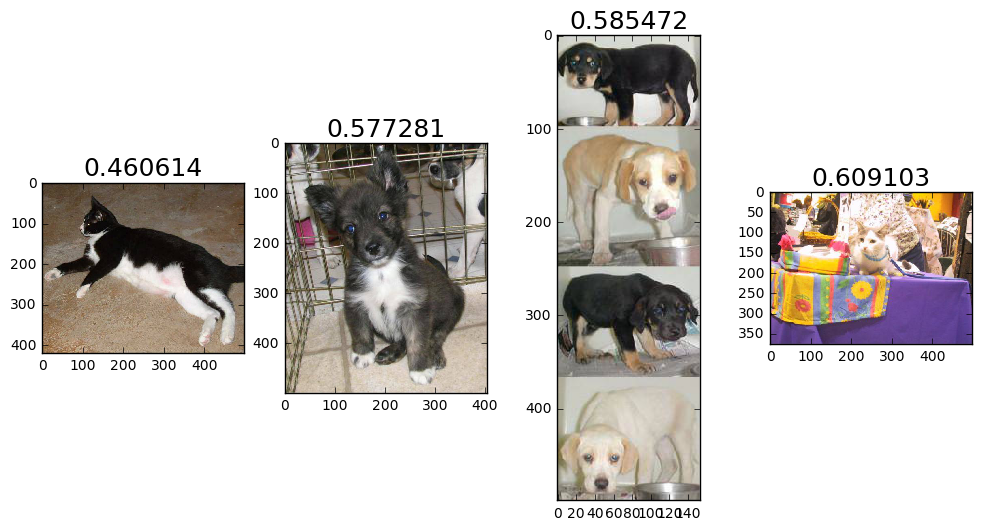

In [40]:
#5. The most uncertain labels (ie those with probability closest to 0.5).
most_uncertain = np.argsort(np.abs(our_predictions-0.5))
plots_idx(most_uncertain[:n_view], our_predictions[most_uncertain])

Perhaps the most common way to analyze the result of a classification model is to use a confusion matrix. Scikit-learn has a convenient function we can use for this purpose:

In [41]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels, our_labels)


We can just print out the confusion matrix, or we can show a graphical view (which is mainly useful for dependents with a larger number of categories).

[[11129    97]
 [  267 11007]]


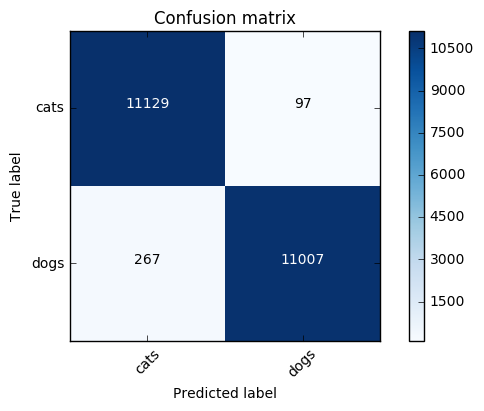

In [42]:
plot_confusion_matrix(cm, val_batches.class_indices)

## Submit Predictions to Kaggle ##

In [57]:
#Load our test predictions from file
preds = load_array(results_path + 'test_preds.dat')
filenames = load_array(results_path + 'filenames.dat')

In [58]:
#Grab the dog prediction column
isdog = preds[:,1]
print ("Raw Predictions: " + str(isdog[:5]))
print ("Mid Predictions: " + str(isdog[(isdog < .6) & (isdog > .4)]))
print ("Edge Predictions: " + str(isdog[(isdog == 1) | (isdog == 0)]))

Raw Predictions: [ 1.  0.  0.  0.  0.]
Mid Predictions: [ 0.4308  0.4551]
Edge Predictions: [ 1.  0.  0. ...,  1.  0.  0.]



Log Loss doesn't support probability values of 0 or 1--they are undefined (and we have many). Fortunately, Kaggle helps us by offsetting our 0s and 1s by a very small value. So if we upload our submission now we will have lots of .99999999 and .000000001 values. This seems good, right?
Not so. There is an additional twist due to how log loss is calculated--log loss rewards predictions that are confident and correct (p=.9999,label=1), but it punishes predictions that are confident and wrong far more (p=.0001,label=1). See visualization below.

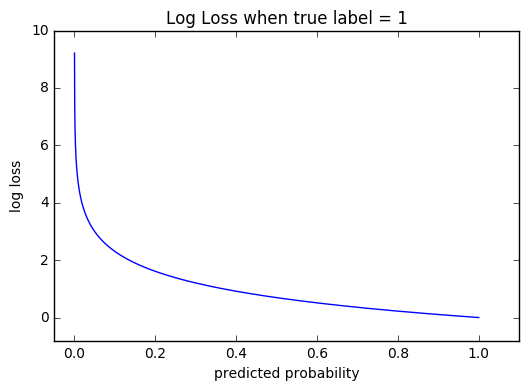

In [59]:
#Visualize Log Loss when True value = 1
#y-axis is log loss, x-axis is probabilty that label = 1
#As you can see Log Loss increases rapidly as we approach 0
#But increases slowly as our predicted probability gets closer to 1
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import log_loss

x = [i*.0001 for i in range(1,10000)]
y = [log_loss([1],[[i*.0001,1-(i*.0001)]],eps=1e-15) for i in range(1,10000,1)]

plt.plot(x, y)
plt.axis([-.05, 1.1, -.8, 10])
plt.title("Log Loss when true label = 1")
plt.xlabel("predicted probability")
plt.ylabel("log loss")

plt.show()

In [60]:
#So to play it safe, we use a sneaky trick to round down our edge predictions
#Swap all ones with .95 and all zeros with .05
isdog = isdog.clip(min=0.02, max=0.98)

In [61]:
#Extract imageIds from the filenames in our test/unknown directory 
filenames = batches.filenames
ids = np.array([int(f[8:f.find('.')]) for f in filenames])

In [62]:
#join two columns into an array of [imageId, isDog]
subm = np.stack([ids,isdog], axis=1)
subm[:5]

array([[  8.9100e+02,   9.8400e-01],
       [  1.0799e+04,   1.6000e-02],
       [  4.1010e+03,   1.6000e-02],
       [  5.1390e+03,   1.6000e-02],
       [  2.7790e+03,   1.6000e-02]])

In [63]:
%cd $DATA_HOME_DIR
submission_file_name = 'submission1.csv'
np.savetxt(submission_file_name, subm, fmt='%d,%.5f', header='id,label', comments='')

/home/pmaroun/data/dogs-vs-cats-redux


In [64]:
from IPython.display import FileLink
%cd $LESSON_HOME_DIR
FileLink(os.path.realpath("/home/pmaroun/data/dogs-vs-cats-redux/")+'/'+submission_file_name)

/home/pmaroun/data/dogs-vs-cats-redux/test


/home/pmaroun/data/dogs-vs-cats-redux/submission1.csv